In [27]:
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u


In [28]:
d = pd.read_csv("data/planets.csv")

# Print the first few rows of the DataFrame
print(d.info())

Gaia.ROW_LIMIT = 10000

# print the row with the planet name: "Earth"

planet = d[d["pl_name"] == "Kepler-1176 b"]

print(planet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5514 entries, 0 to 5513
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pl_name         5514 non-null   object 
 1   hostname        5514 non-null   object 
 2   sy_snum         5514 non-null   int64  
 3   sy_pnum         5514 non-null   int64  
 4   disc_facility   5514 non-null   object 
 5   disc_telescope  5514 non-null   object 
 6   pl_orbper       5271 non-null   float64
 7   pl_orbsmax      5217 non-null   float64
 8   pl_rade         5495 non-null   float64
 9   pl_radj         5494 non-null   float64
 10  pl_bmasse       5488 non-null   float64
 11  pl_bmassj       5488 non-null   float64
 12  pl_bmassprov    5514 non-null   object 
 13  pl_dens         5402 non-null   float64
 14  pl_orbeccen     4749 non-null   float64
 15  pl_insol        3834 non-null   float64
 16  pl_eqt          4072 non-null   float64
 17  pl_orbincl      4224 non-null   f

In [29]:
target_ra = planet["ra"].values[0]
target_dec = planet["dec"].values[0]
target_distance = planet["sy_dist"].values[0]

print(target_ra)
print(target_dec)
print(target_distance)

target_coord = SkyCoord(ra=target_ra * u.deg, dec=target_dec * u.deg, distance=target_distance * u.pc, frame='icrs')

297.919724
45.2742038
864.699


In [33]:
search_distance = 500 # distance in parsecs around the target planet
search_distance = min(search_distance, target_distance)
search_radius = np.arcsin(search_distance/np.sqrt((target_distance-search_distance)**2 + search_distance**2)) * 180/np.pi
max_mag = 10

query = f"""
SELECT
  source_id, ra, dec, parallax, pmra, pmdec, phot_g_mean_mag
FROM gaiadr3.gaia_source
WHERE
  ABS(1000/parallax - {target_distance}) < {search_distance}
  AND 
  1=CONTAINS(
    POINT('ICRS',ra,dec),
    CIRCLE('ICRS',{target_ra},{target_dec},{search_radius})
  )
  AND phot_g_mean_mag <= {max_mag}
  AND parallax IS NOT NULL
  ORDER BY distance_gspphot ASC
"""


job = Gaia.launch_job_async(query)

star_data = []

raw_data = job.get_results()

for row in raw_data:
    distance = 1000 / row["parallax"]

    star = {
        "ra": row["ra"],
        "dec": row["dec"],
        "distance": distance,
        "magnitude": row["phot_g_mean_mag"]
    }
    star_data.append(star)

INFO: Query finished. [astroquery.utils.tap.core]


In [35]:
star_coords = SkyCoord(
    ra=[star["ra"] for star in star_data] * u.deg,
    dec=[star["dec"] for star in star_data] * u.deg,
    distance=[star["distance"] for star in star_data] * u.pc,
    frame='icrs'
)

target_x, target_y, target_z = target_coord.cartesian.xyz.value
zstar_x = star_coords.cartesian.x.value
zstar_y = star_coords.cartesian.y.value
zstar_z = star_coords.cartesian.z.value

star_x = []
star_y = []
star_z = []

magnitudes = [star["magnitude"] for star in star_data]

star_magnitudes = []

i = 0
j=1
for star in star_data:
    # check if the star is within the distance range to the target
    if (zstar_x[i] - target_x)**2 + (zstar_y[i] - target_y)**2 + (zstar_z[i] - target_z)**2 < search_distance**2:  
        star_x.append(zstar_x[i])
        star_y.append(zstar_y[i])
        star_z.append(zstar_z[i])
        star_magnitudes.append(magnitudes[i])
        j += 1
    i += 1
    
# Creating a DataFrame
data = {'x': star_x, 'y': star_y, 'z': star_z, 'magnitude': star_magnitudes}
df = pd.DataFrame(data)

df.to_csv("data/stars.csv", index=False)


# Print the first few stars
print("Star data:", j)


Star data: 26358


In [36]:
import plotly.graph_objs as go

max_range = max(
    np.max(star_x) - target_x, np.max(star_y) - target_y, np.max(star_z) - target_z,
    target_x - np.min(star_x), target_y - np.min(star_y), target_z - np.min(star_z)
)

# Set limits for each axis centered on the target
x_limits = [target_x - max_range, target_x + max_range]
y_limits = [target_y - max_range, target_y + max_range]
z_limits = [target_z - max_range, target_z + max_range]

# Create the central target trace
target_trace = go.Scatter3d(
    x=[target_x], y=[target_y], z=[target_z],
    mode='markers',
    marker=dict(size=10, color='red'),
    name='Central Target'
)

# Create the star cloud trace
star_trace = go.Scatter3d(
    x=star_x, y=star_y, z=star_z,
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Stars'
)

# Define layout with manually set axis limits for equal scaling
layout = go.Layout(
    title='3D Star Field Around Target (Equal Scaling)',
    scene=dict(
        xaxis=dict(title='X (parsecs)', range=x_limits),
        yaxis=dict(title='Y (parsecs)', range=y_limits),
        zaxis=dict(title='Z (parsecs)', range=z_limits),
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=1)  # Enforces equal scaling on all axes
    ),
)

# Create the figure
fig = go.Figure(data=[target_trace, star_trace], layout=layout)

# Show the plot
fig.show()

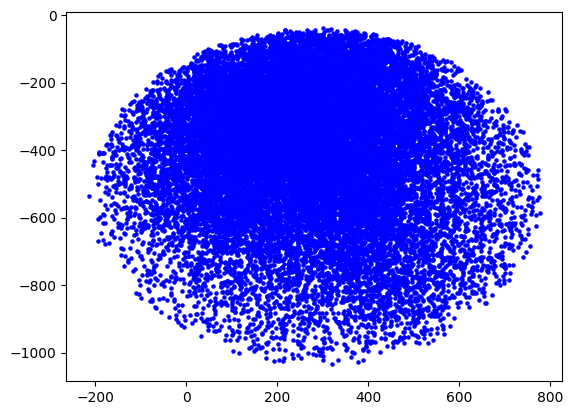

In [37]:
# 2d scatter plot

plt.scatter(star_x, star_y, c='blue', s=5)